In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.generation import extrude
from tyssue import config
from tyssue.core.objects import get_opposite
from tyssue.core.objects import Epithelium

from tyssue.core.sheet import Sheet

from tyssue.geometry.bulk_geometry import BulkGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.geometry.sheet_geometry import SheetGeometry as sgeom

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.stores import load_datasets

In [5]:
def parse_polyhedron(fname):
    '''
    Parses a polynome description provided by Simon Tatham, retrieved frm
    http://www.chiark.greenend.org.uk/~sgtatham/polyhedra/
    
    The software in this archive is copyright 2003,2004 Simon Tatham.

    Permission is hereby granted, free of charge, to any person
    obtaining a copy of this software and associated documentation files
    (the "Software"), to deal in the Software without restriction,
    including without limitation the rights to use, copy, modify, merge,
    publish, distribute, sublicense, and/or sell copies of the Software,
    and to permit persons to whom the Software is furnished to do so,
    subject to the following conditions:

    The above copyright notice and this permission notice shall be
    included in all copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
    EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
    MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
    NONINFRINGEMENT.  IN NO EVENT SHALL THE COPYRIGHT HOLDERS BE LIABLE
    FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF
    CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
    WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
    '''
    
    
    with open(fname, 'r+') as th:
        lines = th.readlines()

    point_lines = [l.split(' ') for l in lines if l.startswith('point')]

    points = np.array([[np.float(s) for s in p[-3:]] for p in point_lines])
    point_ids = [p[1] for p in point_lines]

    vert_df = pd.DataFrame(points, index=pd.Index(point_ids), columns=['x', 'y', 'z'])
    vert_df['int_idx'] = np.arange(vert_df.shape[0])

    face_lines = [l.split(' ')[1:3] for l in lines if l.startswith('face')]
    prev = face_lines[0][0]
    faces = []
    cur = []
    for ff, l in face_lines:
        if ff != prev:
            faces.append(cur)
            cur = [l[:-1]]
            prev = ff
        else:
            cur.append(l[:-1])

    srces = []
    trgts = []
    face_idxs = []
    for i, ff in enumerate(faces):
        srces.extend(vert_df.loc[ff, 'int_idx'])
        trgts.extend(vert_df.loc[np.roll(ff, 1), 'int_idx'])
        face_idxs.extend(np.ones(len(ff))*i)

    edge_df = pd.DataFrame(np.vstack([srces, trgts, face_idxs]).T.astype(np.int),
                           columns=['srce', 'trgt', 'face'])
    edge_df.index.name = 'edge'
    vert_df.set_index('int_idx', drop=True, inplace=True)
    vert_df.index.name = 'vert'
    face_df = pd.DataFrame(index=pd.Index(range(len(faces)), name='face'),
                           columns=['x', 'y', 'z'])

    datasets = {'vert': vert_df,
                'edge': edge_df,
                'face': face_df}

    # specs = load_default('geometry', 'sheet')
    # sheet = Sheet('ti', datasets, specs)
    # geom.update_all(sheet)
    return datasets


In [37]:
apical_datasets = parse_polyhedron('truncatedicosahedron')
specs = config.geometry.sheet_spec()
specs['settings']['geometry'] = 'spherical'

sheet = Sheet('sphere', apical_datasets, specs)

mod_specs = config.dynamics.quasistatic_sheet_spec()
dim_specs = model.dimentionalize(mod_specs)

sheet.update_specs(dim_specs)
pref_area = dim_specs['face']['prefered_area']
sgeom.scale(sheet, np.sqrt(pref_area), sheet.coords)
sgeom.update_all(sheet)
res = solver.find_energy_min(sheet, sgeom, model)
print(res['success'])

True


In [7]:
apical_datasets = parse_polyhedron('truncatedicosahedron')
datasets = extrude(apical_datasets)
specs = config.geometry.sheet_spec()

eptm = Epithelium('truncatedicosahedron', datasets, specs)
geom.update_all(eptm)

In [8]:
%matplotlib qt
draw_specs = {'edge': {'head_width':0.01}}
sheet_view(eptm, **draw_specs)

(<matplotlib.figure.Figure at 0x7f6442863358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6442843128>)

In [9]:
vp_view(eptm)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [38]:
def division_time_table(sheet, mother,
                        events, start_t=0):

    n_steps = sheet.settings['growth_steps']
    times = range(start_t,
                  start_t+n_steps+1)

    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, mother) for t in times],
        names=['t', 'face'])

    time_table = pd.DataFrame(index=cell_time_idx,
                              columns=events.keys())
    pref_vols = np.linspace(1., 2., n_steps)
    time_table.loc[start_t: start_t+n_steps-1, 'grow'] = pref_vols
    time_table.loc[start_t+n_steps, 'divide'] = np.random.random() * np.pi
    return times, time_table.sort_index()


In [39]:
from tyssue.behaviors.sheet_events import SheetEvents

events = SheetEvents(eptm, model, geom).events

NameError: name 'eptm' is not defined

In [107]:
%pdb

Automatic pdb calling has been turned ON


In [13]:
n_steps = 20
eptm.settings['growth_steps'] = n_steps
division_times = np.random.choice(np.arange(eptm.Nc * n_steps), 
                                  size=eptm.Nc)

time_tables = []
for mother, div_time in zip(range(sheet.Nf), division_times):
    times, time_table = division_time_table(sheet, mother,
                                            events, start_t=0)
    time_tables.append(time_table)

NameError: name 'sheet' is not defined

In [8]:
time_tables = pd.concat(time_tables)

In [10]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-6},
        }
    }

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)

res = solver.find_energy_min(sheet, geom, model, **min_settings)

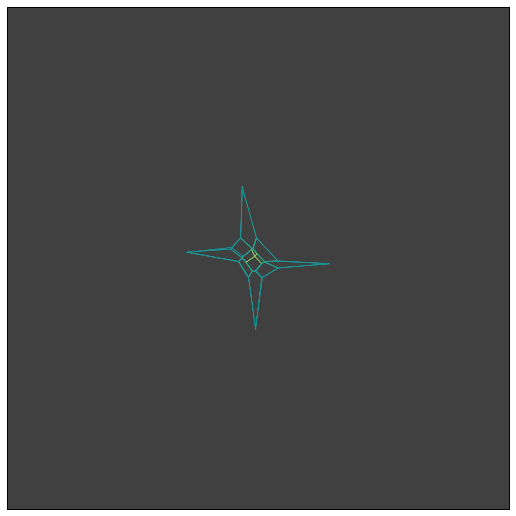

In [14]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            'head_width': 0.,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_frame_on(False)
    fig.set_size_inches((16, 9))
    fig.set_frameon(False)
    fig.set_clip_box(ax.bbox)
    return fig, ax

fig, ax = leg_joint_view(sheet)
plt.savefig('before.png', bbox_inches='tight')

In [ ]:
times = time_tables.index.labels[0]


def time_step(face_events, events,
              sheet, geom, model):

    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            if ((not sheet.face_df.loc[face, 'is_alive']) or
                np.isnan(sheet.face_df.loc[face, 'is_alive'])):
                continue
            events[event_name](face, event_arg)
    res = solver.find_energy_min(sheet, geom, model, **settings)

    
for t in times:
    face_events = time_table.loc[t]
    time_step(face_events, events,
              sheet, geom, model)
    fig, ax = leg_joint_view(sheet)
    figname = 'fold_formation_{:03d}.png'.format(t)
    plt.savefig(figname, bbox_inches='tight')
    plt.close(fig)

In [115]:
time_tables.head()

,,divide,grow,ab_pull,type1_at_shorter,contract,shrink,type3
t,face,,,,,,,
0,0,NaN,1,NaN,NaN,NaN,NaN,NaN
1,0,NaN,1.05263,NaN,NaN,NaN,NaN,NaN
2,0,NaN,1.10526,NaN,NaN,NaN,NaN,NaN
3,0,NaN,1.15789,NaN,NaN,NaN,NaN,NaN
4,0,NaN,1.21053,NaN,NaN,NaN,NaN,NaN


In [100]:
division_times

array([460, 275, 181, 115, 137, 499, 355, 168, 527, 441, 532, 396, 174,
       615, 545, 567, 280, 169, 613, 280, 167, 104, 402, 291, 605,  99,
       159, 198, 212, 263, 310])